Using a subset of CRISA's data records of household panels containing demographic data, purchase data, and basis of purchase data(reasons or promotions based on which a consumer makes a purchase).

The goal is to identify customer segments and define their characterstics for CRISA to create their market segments based on the identified segments. Segments are to be created using Purchase data and basis of purchase as CRISA traditionally segmented customers based on demographics.

In [1]:
#required imports

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise, roc_curve, auc, precision_recall_curve, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart, liftChart
from sklearn.model_selection import train_test_split

In [6]:
bathSoap_df = pd.read_csv('BathSoapHousehold.csv')
bathSoap_df.head()

,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,...,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,1010010,4,3,10,1,4,4,2,4,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028037,0.0,0.130841,0.339564
1,1010020,3,2,10,2,2,4,4,2,1,...,0.347048,0.026834,0.016100,0.014311,0.0,0.059034,0.000000,0.0,0.080501,0.000000
2,1014020,2,3,10,2,4,5,6,4,1,...,0.121212,0.033550,0.010823,0.008658,0.0,0.000000,0.016234,0.0,0.561688,0.003247
3,1014030,4,0,0,0,4,0,0,5,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.600000,0.000000
4,1014190,4,1,10,2,3,4,4,3,1,...,0.000000,0.000000,0.048193,0.000000,0.0,0.000000,0.000000,0.0,0.144578,0.000000


In [7]:
#renaming the columns
bathSoap_df.columns = [s.strip().replace(' ', '_') for s in
bathSoap_df.columns]
bathSoap_df.columns

Index(['Member_id', 'SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD',
       'CS', 'Affluence_Index', 'No._of_Brands', 'Brand_Runs', 'Total_Volume',
       'No._of__Trans', 'Value', 'Trans_/_Brand_Runs', 'Vol/Tran',
       'Avg._Price', 'Pur_Vol_No_Promo_-_%', 'Pur_Vol_Promo_6_%',
       'Pur_Vol_Other_Promo_%', 'Br._Cd._57,_144', 'Br._Cd._55', 'Br._Cd._272',
       'Br._Cd._286', 'Br._Cd._24', 'Br._Cd._481', 'Br._Cd._352', 'Br._Cd._5',
       'Others_999', 'Pr_Cat_1', 'Pr_Cat_2', 'Pr_Cat_3', 'Pr_Cat_4',
       'PropCat_5', 'PropCat_6', 'PropCat_7', 'PropCat_8', 'PropCat_9',
       'PropCat_10', 'PropCat_11', 'PropCat_12', 'PropCat_13', 'PropCat_14',
       'PropCat_15'],
      dtype='object')

In [8]:
#creating lists based on the category of the variable
demographicIndicators = bathSoap_df.columns[1:11]
purchaseIndicator = bathSoap_df.columns[11:19]
withinPromotionIndicator = bathSoap_df.columns[19:22]
brandIndicator = bathSoap_df.columns[22:30]
otherBrandIndicator = bathSoap_df.columns[30:31]
priceCategoryIndicator = bathSoap_df.columns[31:35]
sellingPropertyIndicator = bathSoap_df.columns[35:46]
print('Demographic', demographicIndicators)
print('Purchase', purchaseIndicator)
print('Promotion', withinPromotionIndicator)
print('Brand', brandIndicator)
print('Other brand', otherBrandIndicator)
print('Price category', priceCategoryIndicator)
print('Selling property', sellingPropertyIndicator)

Demographic Index(['SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD', 'CS',
       'Affluence_Index'],
      dtype='object')
Purchase Index(['No._of_Brands', 'Brand_Runs', 'Total_Volume', 'No._of__Trans', 'Value',
       'Trans_/_Brand_Runs', 'Vol/Tran', 'Avg._Price'],
      dtype='object')
Promotion Index(['Pur_Vol_No_Promo_-_%', 'Pur_Vol_Promo_6_%', 'Pur_Vol_Other_Promo_%'], dtype='object')
Brand Index(['Br._Cd._57,_144', 'Br._Cd._55', 'Br._Cd._272', 'Br._Cd._286',
       'Br._Cd._24', 'Br._Cd._481', 'Br._Cd._352', 'Br._Cd._5'],
      dtype='object')
Other brand Index(['Others_999'], dtype='object')
Price category Index(['Pr_Cat_1', 'Pr_Cat_2', 'Pr_Cat_3', 'Pr_Cat_4'], dtype='object')
Selling property Index(['PropCat_5', 'PropCat_6', 'PropCat_7', 'PropCat_8', 'PropCat_9',
       'PropCat_10', 'PropCat_11', 'PropCat_12', 'PropCat_13', 'PropCat_14',
       'PropCat_15'],
      dtype='object')


To identify the loyal customers, we would be creating a variable "maxbrandpurchase" which will capture the max volume purchased from a particular brand out of the given list of brands. Through this we get a customer who is loyal to a brand say A and another who is loyal to B both will be considered loyal.

"maxBrandIndicator" will provide the name corresponding to "maxbrandpurchase"

In [9]:

brand = pd.DataFrame()

#getting the name and corresponding value of the brand preferred the most by a consumer
brand['maxBrandIndicator'] = bathSoap_df.loc[:,['Br._Cd._57,_144', 'Br._Cd._55', 'Br._Cd._272','Br._Cd._286', 'Br._Cd._24', 
                   'Br._Cd._481', 'Br._Cd._352', 'Br._Cd._5']].idxmax(axis=1)

brand['maxbrandpurchase'] = bathSoap_df.loc[:,['Br._Cd._57,_144', 'Br._Cd._55', 'Br._Cd._272','Br._Cd._286', 'Br._Cd._24', 
                   'Br._Cd._481', 'Br._Cd._352', 'Br._Cd._5']].max(axis=1)

In [10]:
#adding the above columns to the dataframe
bathSoap_df['maxBrandIndicator'] = brand['maxBrandIndicator']
bathSoap_df['maxbrandpurchase'] = brand['maxbrandpurchase']
bathSoap_df

,Member_id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,...,PropCat_8,PropCat_9,PropCat_10,PropCat_11,PropCat_12,PropCat_13,PropCat_14,PropCat_15,maxBrandIndicator,maxbrandpurchase
0,1010010,4,3,10,1,4,4,2,4,1,...,0.000000,0.000000,0.000000,0.000000,0.028037,0.000000,0.130841,0.339564,"Br._Cd._57,_144",0.376947
1,1010020,3,2,10,2,2,4,4,2,1,...,0.016100,0.014311,0.000000,0.059034,0.000000,0.000000,0.080501,0.000000,Br._Cd._5,0.144902
2,1014020,2,3,10,2,4,5,6,4,1,...,0.010823,0.008658,0.000000,0.000000,0.016234,0.000000,0.561688,0.003247,Br._Cd._55,0.545455
3,1014030,4,0,0,0,4,0,0,5,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,Br._Cd._55,0.600000
4,1014190,4,1,10,2,3,4,4,3,1,...,0.048193,0.000000,0.000000,0.000000,0.000000,0.000000,0.144578,0.000000,Br._Cd._55,0.144578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1167090,2,3,10,2,4,5,5,4,1,...,0.000000,0.000000,0.024931,0.897507,0.000000,0.000000,0.000000,0.000000,Br._Cd._481,0.897507
596,1167230,3,3,10,2,3,5,4,4,1,...,0.148515,0.000000,0.039604,0.000000,0.000000,0.089109,0.000000,0.049505,Br._Cd._5,0.103960
597,1167340,3,3,17,2,4,4,9,4,1,...,0.030928,0.000000,0.038660,0.000000,0.000000,0.000000,0.180412,0.000000,"Br._Cd._57,_144",0.246564
598,1167350,2,1,4,2,4,5,2,4,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027273,0.136364,0.000000,Br._Cd._55,0.109091


In [11]:
#creating a combined list of behaviour indicators
behaviorIndicator = list(purchaseIndicator) + list(otherBrandIndicator) + ['maxBrandIndicator'] + ['maxbrandpurchase']

In [13]:
#creating a combined list of indicators on which users decide their purchase
purchaseBasisIndicator = list(withinPromotionIndicator) + list(priceCategoryIndicator)
purchaseBasisIndicator.extend(['PropCat_5', 'PropCat_14'])

In [14]:
combinedIndicator = behaviorIndicator + purchaseBasisIndicator
combinedIndicator

['No._of_Brands',
 'Brand_Runs',
 'Total_Volume',
 'No._of__Trans',
 'Value',
 'Trans_/_Brand_Runs',
 'Vol/Tran',
 'Avg._Price',
 'Others_999',
 'maxBrandIndicator',
 'maxbrandpurchase',
 'Pur_Vol_No_Promo_-_%',
 'Pur_Vol_Promo_6_%',
 'Pur_Vol_Other_Promo_%',
 'Pr_Cat_1',
 'Pr_Cat_2',
 'Pr_Cat_3',
 'Pr_Cat_4',
 'PropCat_5',
 'PropCat_14']

In [15]:
both_df = ['Member_id'] + combinedIndicator;
purchaseBehaviour_df = bathSoap_df[both_df];
purchaseBehaviour_df

,Member_id,No._of_Brands,Brand_Runs,Total_Volume,No._of__Trans,Value,Trans_/_Brand_Runs,Vol/Tran,Avg._Price,Others_999,...,maxbrandpurchase,Pur_Vol_No_Promo_-_%,Pur_Vol_Promo_6_%,Pur_Vol_Other_Promo_%,Pr_Cat_1,Pr_Cat_2,Pr_Cat_3,Pr_Cat_4,PropCat_5,PropCat_14
0,1010010,3,17,8025,24,818.00,1.41,334.38,10.19,0.492212,...,0.376947,1.000000,0.000000,0.000000,0.233645,0.560748,0.130841,0.074766,0.501558,0.130841
1,1010020,5,25,13975,40,1681.50,1.60,349.38,12.03,0.699463,...,0.144902,0.887299,0.096601,0.016100,0.293381,0.547406,0.094812,0.064401,0.456172,0.080501
2,1014020,5,37,23100,63,1950.00,1.70,366.67,8.44,0.378788,...,0.545455,0.941558,0.019481,0.038961,0.120130,0.318182,0.561688,0.000000,0.244589,0.561688
3,1014030,2,4,1500,4,114.00,1.00,375.00,7.60,0.000000,...,0.600000,1.000000,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,0.400000,0.600000
4,1014190,3,6,8300,13,591.00,2.17,638.46,7.12,0.807229,...,0.144578,0.614458,0.144578,0.240964,0.000000,0.048193,0.144578,0.807229,0.807229,0.144578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1167090,3,5,9025,22,1218.00,4.40,410.23,13.50,0.058172,...,0.897507,0.775623,0.224377,0.000000,0.058172,0.941828,0.000000,0.000000,0.077562,0.000000
596,1167230,5,23,5050,28,851.00,1.22,180.36,16.85,0.678218,...,0.103960,0.925743,0.074257,0.000000,0.534653,0.366337,0.000000,0.099010,0.168317,0.000000
597,1167340,4,19,29100,25,3302.75,1.32,1164.00,11.35,0.557560,...,0.246564,1.000000,0.000000,0.000000,0.170103,0.649485,0.180412,0.000000,0.622852,0.180412
598,1167350,3,15,5500,19,460.00,1.27,289.47,8.36,0.863636,...,0.109091,0.759091,0.186364,0.054545,0.136364,0.509091,0.209091,0.145455,0.690909,0.136364


In [16]:
#creating binary variables for maxBrandIndicator
purchaseBehaviour_df = pd.get_dummies(purchaseBehaviour_df, columns=['maxBrandIndicator'])
purchaseBehaviour_df.columns

Index(['Member_id', 'No._of_Brands', 'Brand_Runs', 'Total_Volume',
       'No._of__Trans', 'Value', 'Trans_/_Brand_Runs', 'Vol/Tran',
       'Avg._Price', 'Others_999', 'maxbrandpurchase', 'Pur_Vol_No_Promo_-_%',
       'Pur_Vol_Promo_6_%', 'Pur_Vol_Other_Promo_%', 'Pr_Cat_1', 'Pr_Cat_2',
       'Pr_Cat_3', 'Pr_Cat_4', 'PropCat_5', 'PropCat_14',
       'maxBrandIndicator_Br._Cd._24', 'maxBrandIndicator_Br._Cd._272',
       'maxBrandIndicator_Br._Cd._286', 'maxBrandIndicator_Br._Cd._352',
       'maxBrandIndicator_Br._Cd._481', 'maxBrandIndicator_Br._Cd._5',
       'maxBrandIndicator_Br._Cd._55', 'maxBrandIndicator_Br._Cd._57,_144'],
      dtype='object')

In [17]:
# Load and preprocess data
purchaseBehaviour_df.set_index('Member_id', inplace=True)
purchaseBehaviour_df

,No._of_Brands,Brand_Runs,Total_Volume,No._of__Trans,Value,Trans_/_Brand_Runs,Vol/Tran,Avg._Price,Others_999,maxbrandpurchase,...,PropCat_5,PropCat_14,maxBrandIndicator_Br._Cd._24,maxBrandIndicator_Br._Cd._272,maxBrandIndicator_Br._Cd._286,maxBrandIndicator_Br._Cd._352,maxBrandIndicator_Br._Cd._481,maxBrandIndicator_Br._Cd._5,maxBrandIndicator_Br._Cd._55,"maxBrandIndicator_Br._Cd._57,_144"
Member_id,,,,,,,,,,,,,,,,,,,,,
1010010,3,17,8025,24,818.00,1.41,334.38,10.19,0.492212,0.376947,...,0.501558,0.130841,0,0,0,0,0,0,0,1
1010020,5,25,13975,40,1681.50,1.60,349.38,12.03,0.699463,0.144902,...,0.456172,0.080501,0,0,0,0,0,1,0,0
1014020,5,37,23100,63,1950.00,1.70,366.67,8.44,0.378788,0.545455,...,0.244589,0.561688,0,0,0,0,0,0,1,0
1014030,2,4,1500,4,114.00,1.00,375.00,7.60,0.000000,0.600000,...,0.400000,0.600000,0,0,0,0,0,0,1,0
1014190,3,6,8300,13,591.00,2.17,638.46,7.12,0.807229,0.144578,...,0.807229,0.144578,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167090,3,5,9025,22,1218.00,4.40,410.23,13.50,0.058172,0.897507,...,0.077562,0.000000,0,0,0,0,1,0,0,0
1167230,5,23,5050,28,851.00,1.22,180.36,16.85,0.678218,0.103960,...,0.168317,0.000000,0,0,0,0,0,1,0,0
1167340,4,19,29100,25,3302.75,1.32,1164.00,11.35,0.557560,0.246564,...,0.622852,0.180412,0,0,0,0,0,0,0,1


In [18]:
purchaseBehaviour_df = purchaseBehaviour_df.apply(lambda x: x.astype('float64'))
# Normalize distances
purchaseBehaviour_df_norm = purchaseBehaviour_df.apply(preprocessing.scale, axis=0)

To create segments of customers we would be performing clustering. The number of clusters would be based on how many types of segments CRISA wants to identify. So we would be characterstics of segments with number of clusters as 2,3 and 4.

In [19]:
def clustering(k):
    kmeans = KMeans(n_clusters=k,random_state=0).fit(purchaseBehaviour_df_norm)
    # Cluster membership
    memb = pd.Series(kmeans.labels_, index=purchaseBehaviour_df_norm.index)
    for key, item in memb.groupby(memb):
        print('Cluster',key, ':' , (item.index))
    #calculating centroid values for each variable under a cluster
    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=purchaseBehaviour_df_norm.columns)
    pd.set_option('precision', 3)
    centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
    #plotting the centriod values
    plt.figure(figsize=(15,6)) # set the figure size
    parallel_coordinates(centroids, class_column='cluster',
    colormap='Dark2', linewidth=5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=90) # rotate x-axis labels
    #grouping the demographic indicator based on the cluster
    demographic_indicators_df= bathSoap_df[demographicIndicators].groupby(kmeans.labels_).median()
    demographic_indicators_df['cluster'] = ['Cluster {}'.format(i) for i in demographic_indicators_df.index]
    #plotting median values for each variable under a cluster 
    plt.figure(figsize=(15,6))
    parallel_coordinates(demographic_indicators_df, class_column='cluster',
    colormap='Dark2', linewidth=5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=90) # rotate x-axis labels

Cluster 0 : Int64Index([1014020, 1014030, 1017160, 1025140, 1025210, 1027040, 1027160,
            1027210, 1027680, 1027720, 1027810, 1027840, 1028020, 1030040,
            1030150, 1030280, 1030300, 1034020, 1035100, 1037050, 1037190,
            1037250, 1037420, 1037690, 1037890, 1037940, 1038110, 1040080,
            1044010, 1044370, 1045060, 1045100, 1047350, 1047420, 1050050,
            1054110, 1054270, 1055260, 1057150, 1057410, 1057510, 1058350,
            1060330, 1060810, 1061500, 1061940, 1062220, 1062310, 1065040,
            1065450, 1065510, 1065710, 1070040, 1070070, 1070140, 1070980,
            1071340, 1071460, 1075520, 1077390, 1077500, 1080180, 1080690,
            1080820, 1081110, 1081820, 1081900, 1082110, 1082190, 1082210,
            1082260, 1085080, 1085480, 1085530, 1085590, 1095140, 1097370,
            1100490, 1105130, 1106020, 1111180, 1111710, 1115100, 1125840,
            1137610, 1150970, 1156220, 1157860, 1158080, 1163830],
           dtype='int

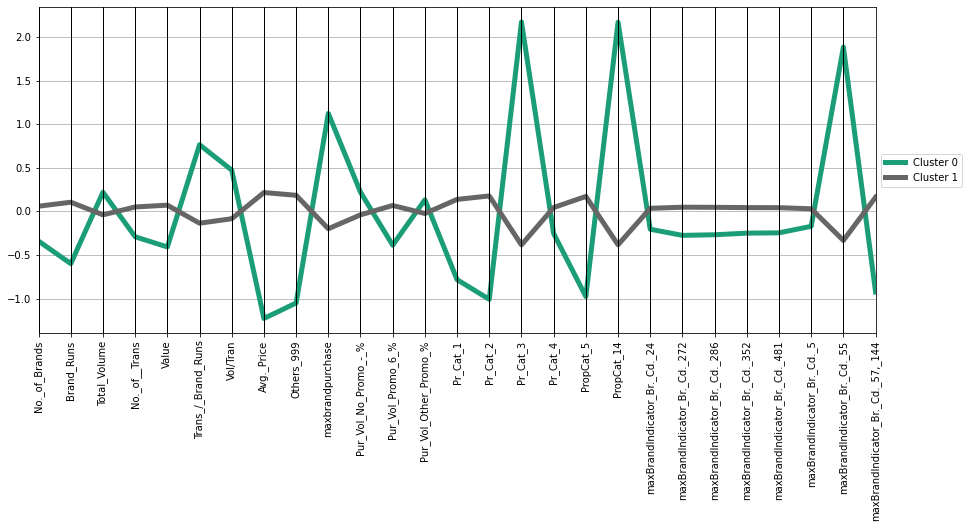

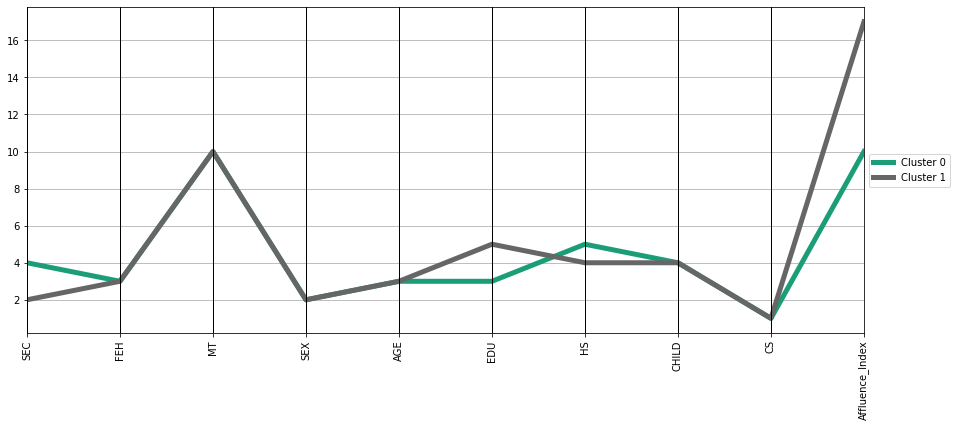

In [20]:
#k=2
clustering(2)

#charcterstics of clusters

cluster-1: more educated,affluent high spenders but not loyal

cluster-0: Budget Conscious, Low spenders, but consistently loyal

Cluster 0 : Int64Index([1010010, 1014190, 1017020, 1017110, 1017360, 1020210, 1024050,
            1024100, 1024120, 1024400,
            ...
            1165330, 1165460, 1166020, 1166080, 1166470, 1166960, 1166980,
            1167090, 1167340, 1167670],
           dtype='int64', name='Member_id', length=261)
Cluster 1 : Int64Index([1014020, 1014030, 1017160, 1025140, 1025210, 1027040, 1027160,
            1027210, 1027680, 1027720, 1027810, 1027840, 1028020, 1030040,
            1030150, 1030280, 1030300, 1034020, 1035100, 1037050, 1037190,
            1037250, 1037420, 1037690, 1037890, 1037940, 1038110, 1040080,
            1044010, 1044370, 1045060, 1045100, 1047350, 1047420, 1050050,
            1054110, 1054270, 1055260, 1057150, 1057410, 1057510, 1058350,
            1060330, 1060810, 1061500, 1061940, 1062220, 1062310, 1065040,
            1065450, 1065510, 1065710, 1070040, 1070070, 1070140, 1070980,
            1071340, 1071460, 1075520, 1077390, 1077500, 1080180, 1080690,


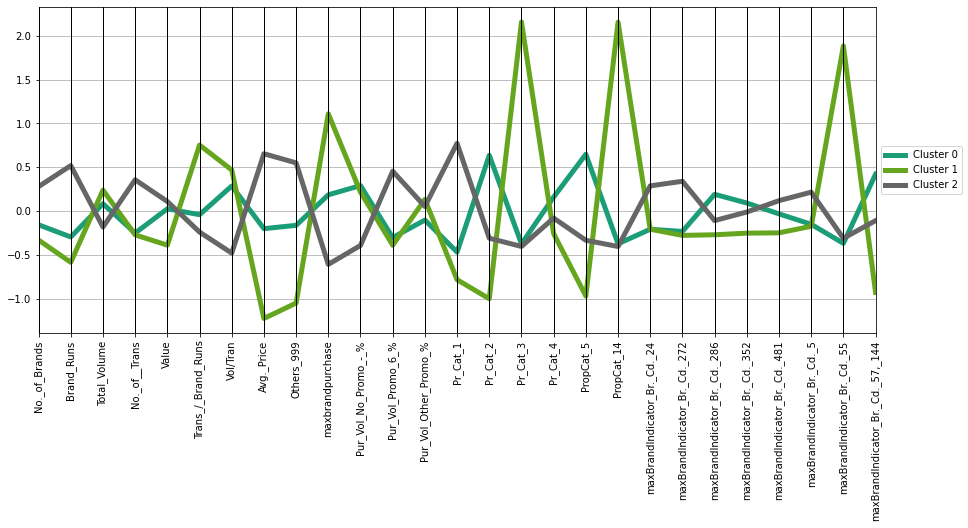

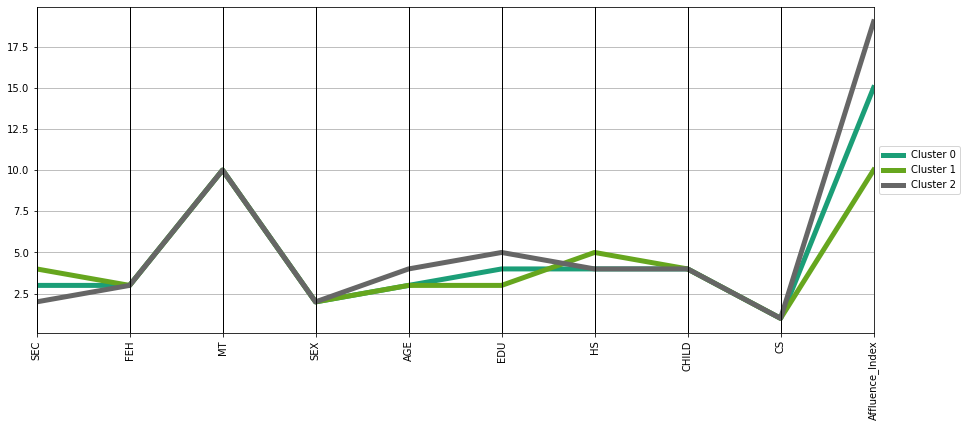

In [21]:
#k=3
clustering(3)

#charcterstics of clusters

cluster-0: more affluent than cluster 1, responsive to price category 2, proposition category 5

cluster-1: Budget Conscious, Low spenders, but consistently loyal. responsive to price category 3 and selling proposition 14.

cluster-2: most affluent, highest educational level, high value purchasers, frequent shoppers but not loyal to any particular brand, respondise to price category 1

Cluster 0 : Int64Index([1010010, 1014190, 1017110, 1017360, 1020210, 1024050, 1024100,
            1024400, 1024630, 1027480,
            ...
            1163300, 1165330, 1165460, 1166470, 1166870, 1166960, 1166980,
            1167090, 1167340, 1167670],
           dtype='int64', name='Member_id', length=200)
Cluster 1 : Int64Index([1010020, 1017020, 1017490, 1020070, 1024120, 1024220, 1027390,
            1028050, 1035150, 1037220,
            ...
            1163760, 1165010, 1165100, 1165160, 1165390, 1165720, 1166020,
            1166080, 1166460, 1167350],
           dtype='int64', name='Member_id', length=199)
Cluster 2 : Int64Index([1014020, 1014030, 1017160, 1025140, 1025210, 1027040, 1027160,
            1027210, 1027680, 1027720, 1027810, 1027840, 1028020, 1030040,
            1030150, 1030280, 1030300, 1034020, 1035100, 1037050, 1037190,
            1037250, 1037420, 1037690, 1037890, 1037940, 1038110, 1044010,
            1044370, 1045060, 1045100, 1047350, 1047420, 10500

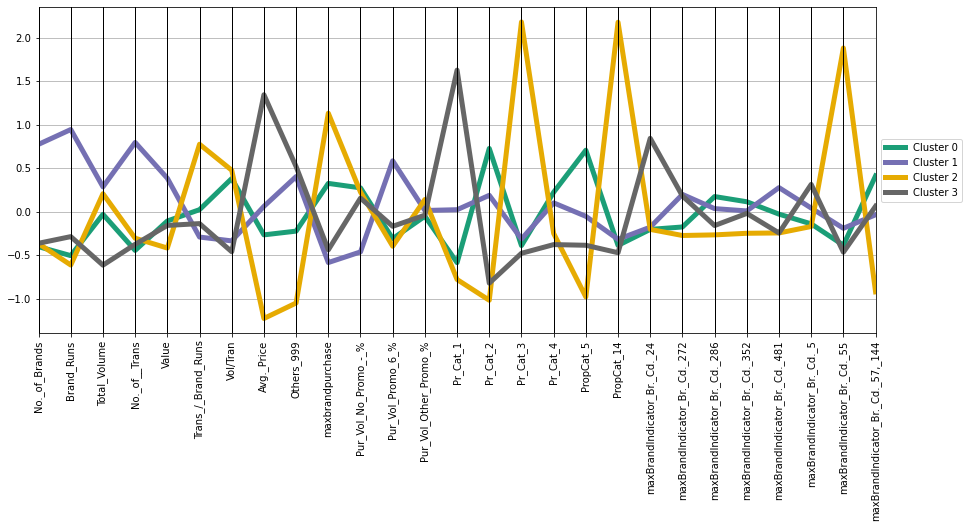

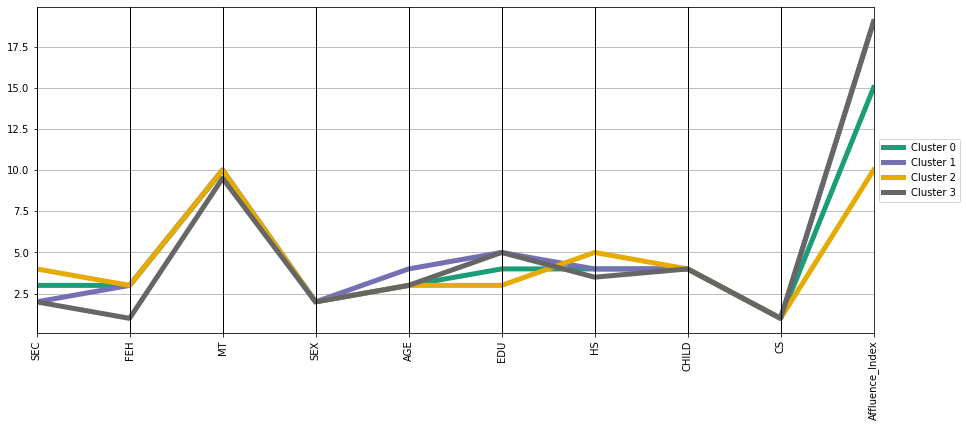

In [22]:
#k=4
clustering(4)

#charcterstics of clusters

cluster-0: more affluent than cluster 1, responsive to price category 2, proposition category 5

cluster-1:affluence same as cluster 3, older than other segments, most frequent purchasers, switch between brands more than any other segment, purchased more than other segments under promotion code 6.

cluster-2: value Conscious, Low spenders, but loyal to a brand. responsive to price category 3 and selling proposition 14.

cluster-3: inclination towards vegetarian diet, most affluent, high value purchasers, not loyal to any particular brand although have some inclination to brand Br.cd.24, responsive to price category 1

# segmentation to consider

There is no single "right" approach to clustering; different approaches are feasible depending on different marketing purposes. CRISA is a marketing agency and owns the data, which it collected at considerable expense, so it will want to be able to use both the data and the segmentation analysis in different ways for different clients. Stating the above doing a segmenation with 4 clusters seems to bring out the distinction between the segments the most.

C:\Users\harsh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


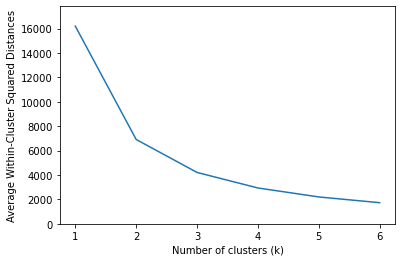

In [25]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(purchaseBehaviour_df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia':inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

The above elbow chart depicts that the heterogenity reduction beyond cluster 4 is not significant. heterogenity reduction is looked at because we want the clusters to be as homogeneous as possible and as two clusters to be as different as possible

Next we'll predict whether a customer will be value conscious or not by using 2 clusters. given the characterstics we defined for the two segments, we had one cluster as value conscious so we will create a binary derived variable and assign the records in cluster 0 as 1 and in cluster 1 as 0.

We will be basing our predictions on the demographic data of the customers.

In [26]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(purchaseBehaviour_df_norm)
# Cluster membership
memb = pd.Series(kmeans.labels_, index=purchaseBehaviour_df_norm.index)
#getting the member id's and adding them to lists after ruuning clustering for k=2
cust_0 = []
cust_1 = []
for key, item in memb.groupby(memb):
    if key == 0:
        cust_0 = list(item.index)
    else:
        cust_1 = list(item.index)

In [27]:
demographicInd = ['Member_id'] + list(demographicIndicators) 
modelData_df = bathSoap_df[demographicInd].copy()
#creating dataframe from the lists above
df1 = modelData_df[modelData_df["Member_id"].isin(cust_0)]
#classifying df2 as price consicious based on the centriod values in k=2 line plot
df2 = modelData_df[modelData_df["Member_id"].isin(cust_1)]#value conscious

In [28]:
#adding target column value_conscious with value 0 for df1(cluster-0)
valueCons = []
for i in range(len(df1)):
        valueCons.append(0)
df1 = df1.assign(value_conscious = valueCons)

In [29]:
#adding target column value_conscious with value 1 for df2(cluster-1)
valueCons = []
for i in range(len(df2)):
        valueCons.append(1)
df2= df2.assign(value_conscious = valueCons)

In [30]:
#merging the the two dataframe to run logistic
value_df = pd.concat([df1,df2])
value_df

,Member_id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence_Index,value_conscious
2,1014020,2,3,10,2,4,5,6,4,1,23,0
3,1014030,4,0,0,0,4,0,0,5,0,0,0
7,1017160,4,3,10,2,2,4,5,3,0,0,0
20,1025140,4,0,0,0,2,0,0,5,0,0,0
21,1025210,2,3,17,2,2,5,5,2,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,1167090,2,3,10,2,4,5,5,4,1,15,1
596,1167230,3,3,10,2,3,5,4,4,1,29,1
597,1167340,3,3,17,2,4,4,9,4,1,13,1
598,1167350,2,1,4,2,4,5,2,4,2,20,1


In [31]:
value_df = pd.get_dummies(value_df, columns=['MT', 'FEH', 'SEC', 'EDU'])
value_df.columns

Index(['Member_id', 'SEX', 'AGE', 'HS', 'CHILD', 'CS', 'Affluence_Index',
       'value_conscious', 'MT_0', 'MT_3', 'MT_4', 'MT_5', 'MT_6', 'MT_8',
       'MT_9', 'MT_10', 'MT_12', 'MT_13', 'MT_14', 'MT_15', 'MT_16', 'MT_17',
       'MT_19', 'FEH_0', 'FEH_1', 'FEH_2', 'FEH_3', 'SEC_1', 'SEC_2', 'SEC_3',
       'SEC_4', 'EDU_0', 'EDU_1', 'EDU_2', 'EDU_3', 'EDU_4', 'EDU_5', 'EDU_6',
       'EDU_7', 'EDU_8', 'EDU_9'],
      dtype='object')

In [32]:
#60-40 split b/w training and validation data. 60-40 split b/w the outcome varible data as well
# partition data
y = value_df['value_conscious']
X = value_df.drop(columns=['value_conscious','Member_id'])
train_X, valid_X, train_y, valid_y = train_test_split(X, y,
test_size=0.4, random_state=1)
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42,
solver='newton-cg')
logit_reg.fit(train_X, train_y)
print('intercept ', logit_reg.intercept_[0]) # the value of Y when all X=0. value of beta-0

intercept  6.223476352471068


In [33]:
#coefficients of the predictors
print(pd.DataFrame({'coeff': logit_reg.coef_[0]},
index=X.columns).transpose())

         SEX   AGE     HS  CHILD    CS  Affluence_Index   MT_0   MT_3   MT_4  \
coeff  0.617  0.38  0.052 -0.064 -0.62            0.047 -0.692  7.009 -6.843   

        MT_5  ...  EDU_0  EDU_1  EDU_2  EDU_3  EDU_4  EDU_5   EDU_6  EDU_7  \
coeff -6.819  ... -5.769 -4.295 -3.141  -3.19 -3.122 -2.277  11.324 -3.468   

       EDU_8  EDU_9  
coeff   10.6   9.56  

[1 rows x 39 columns]


In [34]:
#creating dataframe of predicted vs actual and their associated probability of falling under 0 or 1
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
'probability_0': [p[0] for p in
logit_reg_proba],
'probability_1': [p[1] for p in
logit_reg_proba],
'predicted': logit_reg_pred })
logit_result

,actual,probability_0,probability_1,predicted
441,1,0.063,0.937,1
399,1,0.021,0.979,1
506,1,0.188,0.812,1
450,1,0.247,0.753,1
166,1,0.156,0.844,1
...,...,...,...,...
17,1,0.368,0.632,1
553,1,0.005,0.995,1
354,1,0.054,0.946,1
358,1,0.025,0.975,1


Given our imbalance in our dataset we would be looking at precision rather than accuracy.

It is calculated as the number of true positives divided by the total number of true positives and false positives.

Precision = TruePositives / (TruePositives + FalsePositives)

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

It is calculated as the number of true positives divided by the total number of true positives and false negatives (e.g. it is the true positive rate).

Recall = TruePositives / (TruePositives + FalseNegatives)

f1 score is calculated as below:

f1 score = 2*(precision*recall)/(precision+recall)

In [40]:
#Calculating and printing the f1 score on validation data 
f1_test = f1_score(train_y, logit_reg.predict(train_X))
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.9294478527607362


In [39]:
#Calculating and printing the f1 score on validation data 
f1_test = f1_score(valid_y, logit_reg.predict(valid_X))
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.9146919431279621


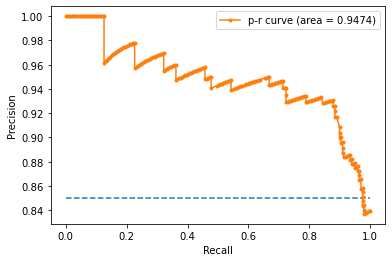

In [35]:
#precision-recall curve
# retrieve just the probabilities for the positive class - will fetch probability_1
pos_probs = logit_reg_proba[:, 1]
# calculate the no skill line as the proportion of the positive class(to show how better our model is)
#where value_conscious =1 out of total
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(valid_y, pos_probs)
#calculating the auc score
auc_score = auc(recall, precision)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='p-r curve (area = %0.4f)' % auc_score)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(loc="upper right")
# show the plot
plt.show()

p-r curve area would usually be used to compare different model performances. In general however a high area indicates our model has a high precision which means that it is able to predict who will be a value conscious customers with high accuracy.

References:

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/    case taken from book Shmueli, G., Bruce, P. C., Gedeck, P., & Patel, N. R. (2019). Data Mining for Business Analytics: Concepts, Techniques and Applications in Python (1st ed.). Wiley.